In [1]:
!pip3 install cadCAD==0.4.27
!pip install matplotlib
import random
from numpy.random import rand
import matplotlib.pyplot as plt
import pandas as pd


  Using cached cadCAD-0.4.27-py3-none-any.whl (57 kB)
  Attempting uninstall: cadCAD
    Found existing installation: cadCAD 0.4.28
    Uninstalling cadCAD-0.4.28:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'AUTHORS.txt'
Consider using the `--user` option or check the permissions.

  Using cached matplotlib-3.5.2-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached Pillow-9.1.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached fonttools-4.33.3-py3-none-any.whl (930 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.5 MB/s eta 0:00:00 0:00:01


# Water Model of the Grand Ethiopian Renaissance Dam

BACKGROUND: 

Ethiopia is in the process of building a massive dam on the Nile river called the Grand Ethiopian Renaissance Dam. This dam will provide water and power for the people of Ethiopia, but there is concern by Egypt (who is down river of the Nile) that this dam will greatly affect the amount of water they receive from the Nile. There are many estimates of how long it would take to fill the reservoir, anywhere between 2 to 40 years, each with a big impact to the goals of Ethiopia and Egypt.

MODEL PURPOSE: 

The purpose of this model is not to analyze the hydro politics between the two countries. Rather, the goal is to create a model that observes the effects of different number of years to fill the reservoir behind the dam and how each timeline affects how much water flows down the Nile into Egypt.

All water is measured in CUBIC METERS (m^3)

ABBREVIATIONS 

GERD: Grand Ethiopian Renaissance Dam
 
ASSUMPTIONS:
- 
The water flow of the Blue Nile River can pass through the GERD at its normal flow levels.  Otherwise the dam would always have uncontrolled spillover, using the Auxilary Spillway once the reservoir as at full capacity.

In [2]:
genesis_states = {
    'Reservoir_Capacity': 73000,        #The total amount of water that the Grand Ethiopian Renaissance Dam's reservoir can hold.
    'Reservoir_Level': 0,               #The starting amount of water within the GERD's reservoir.
    'Reserve_Percent': .05,              #A variable that will be updated with each time step that keeps track of how much of the water flowing through the dam to hold back to fill the reservoir.
    'Current_Month': 0,                 #Tracks what month the model is in so that the proper river water level can be pulled.
    'Number_of_Years': 0                #Tracks how many years it takes to fill the reservoir.
}

In [3]:
df = pd.DataFrame({
    'Month':['January','February','March','April','May','June','July','August','September','October','November','December'],
    'Blue_Nile_Water_Flow':[724,448,406,427,503,1084,4989,15237,13625,7130,2451,1257],
    'White_Nile_Water_Flow':[2469,1905,2014,2225,2026,1792,1368,1435,2236,3024,2786,2747],
    'Atbara_River_Water_Flow':[17,6,1,3,8,88,1536,5126,3306,770,145,46],
    'Total_Water_Flow':[3210,2359,2421,2655,2537,2964,7893,21798,19167,10924,5382,4050]
  
})

df

,Month,Blue_Nile_Water_Flow,White_Nile_Water_Flow,Atbara_River_Water_Flow,Total_Water_Flow
0,January,724,2469,17,3210
1,February,448,1905,6,2359
2,March,406,2014,1,2421
3,April,427,2225,3,2655
4,May,503,2026,8,2537
5,June,1084,1792,88,2964
6,July,4989,1368,1536,7893
7,August,15237,1435,5126,21798
8,September,13625,2236,3306,19167
9,October,7130,3024,770,10924


<AxesSubplot:xlabel='Month'>

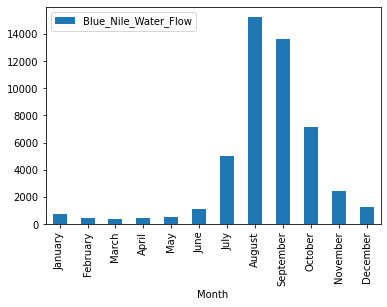

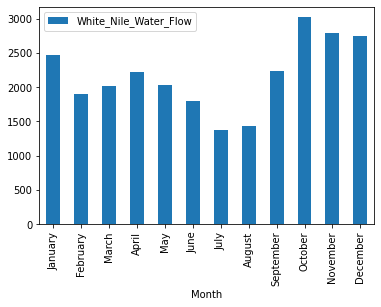

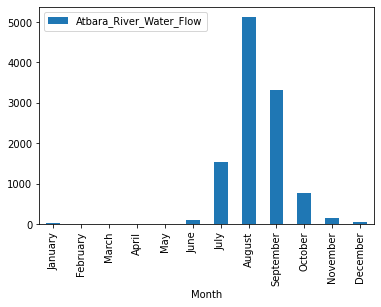

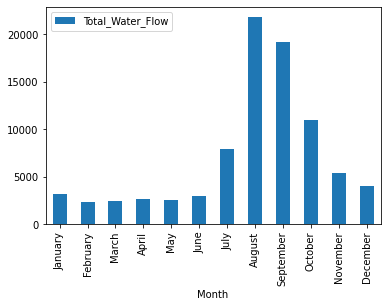

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Water flow bar charts for each of the rivers within the Model
df.plot(kind='bar',x='Month',y='Blue_Nile_Water_Flow')
df.plot(kind='bar',x='Month',y='White_Nile_Water_Flow')
df.plot(kind='bar',x='Month',y='Atbara_River_Water_Flow')
df.plot(kind='bar',x='Month',y='Total_Water_Flow')

In [5]:
#Policies

def Dam_Policy(params, step, sL, s):
  f = 0
  m = s['Current_Month']

  if s['Reservoir_Level'] < s['Reservoir_Capacity']:
    f = df.at[m, 'Blue_Nile_Water_Flow'] * s['Reserve_Percent']
    if m == 11:
      u = -11
      y = 1
    else:
      u = 1
      y = 0
    return({'Dam_Reserve': f, 'Month_Update': u, 'Year_Update': y})
  else:
    f = 0
    if m == 11:
      u = -11
      y = 0
    else:
      u = 1
      y = 0
    return({'Dam_Reserve': f, 'Month_Update': u, 'Year_Update': y})



In [6]:
#Variables

def Reservoir_Update(params, step, sL, s, _input):
  k = 'Reservoir_Level'
  v = s['Reservoir_Level'] + _input['Dam_Reserve']
  return (k,v)

def Month_Update(params, step, sL, s, _input):
  k = 'Current_Month'
  v = s['Current_Month'] + _input['Month_Update']
  return (k,v)

def Year_Update(params, step, sL, s, _input):
  k = 'Number_of_Years'
  v = s['Number_of_Years'] + _input['Year_Update']
  return (k,v)

In [7]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, the user specifies if state update functions will be run in series or in parallel
partial_state_update_blocks = [
    {
        'policies': {
            'Dam_Policy': Dam_Policy
        },    
        'variables': {
            'Reservoir_Level': Reservoir_Update,
            'Current_Month': Month_Update,
            'Number_of_Years' : Year_Update
        }
    }

]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [8]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps
# We'll cover the `M` key in a future article. For now, let's leave it empty
simulation_parameters = {
    'T': range(400),
    'N': 1,
    # 'M': {}
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [9]:
#imported some addition utilities to help with configuration set-up
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
# from cadCAD import configs

exp = Experiment()
c = config_sim(simulation_parameters)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
# del configs[:]
exp.append_configs(
    # model_id = 'sys_model',
    initial_state=genesis_states, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=c #preprocessed dictionaries containing simulation parameters
                       
                      )
# %%capture
from cadCAD.engine import ExecutionContext, Executor,ExecutionMode
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)

from cadCAD.engine import Executor

simulation = Executor(exec_context=local_mode_ctx, configs=exp.configs) # Pass the configuration object inside an array
raw_system_events, tensor_field, sessions = simulation.execute() # The `execute()` method returns a tuple; its first elements contains the raw results


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 400, 0, 1, 5)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (400, 0, 1, 5)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 0.02s


In [10]:
# #imported some addition utilities to help with configuration set-up
# from cadCAD.configuration.utils import config_sim
# from cadCAD.configuration import Experiment
# from cadCAD import configs

# exp = Experiment()
# c = config_sim(simulation_parameters)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # The configurations above are then packaged into a `Configuration` object
# del configs[:]
# exp.append_configs(
#     # model_id = 'sys_model',
#     initial_state=genesis_states, #dict containing variable names and initial values
#     partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
#     sim_configs=c #preprocessed dictionaries containing simulation parameters
                       
#                       )
# # %%capture
# from cadCAD.engine import ExecutionMode, ExecutionContext
# exec_mode = ExecutionMode()
# local_mode_ctx = ExecutionContext(exec_mode.local_mode)

# from cadCAD.engine import Executor

# simulation = Executor(exec_context=local_mode_ctx, configs=configs) # Pass the configuration object inside an array
# raw_system_events, tensor_field, sessions = simulation.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

In [11]:
%matplotlib inline
import pandas as pd
df = pd.DataFrame(raw_system_events)
df.set_index(['run', 'timestep', 'substep'])

Reservoir_Capacity  Reservoir_Level  Reserve_Percent  \
run timestep substep                                                         
1   0        0                     73000             0.00             0.05   
    1        1                     73000            36.20             0.05   
    2        1                     73000            58.60             0.05   
    3        1                     73000            78.90             0.05   
    4        1                     73000           100.25             0.05   
...                                  ...              ...              ...   
    396      1                     73000         73612.40             0.05   
    397      1                     73000         73612.40             0.05   
    398      1                     73000         73612.40             0.05   
    399      1                     73000         73612.40             0.05   
    400      1                     73000         73612.40             0.05   

                      Current_Month  Number_of_Years  simulation  subset  
run timestep substep                                                      
1   0        0                    0                0           0       0  
    1        1                    1                0           0       0  
    2        1                    2                0           0       0  
    3        1                    3                0           0       0  
    4        1                    4                0           0       0  
...                             ...              ...         ...     ...  
    396      1                    0               30           0       0  
    397      1                    1               30           0       0  
    398      1                    2               30           0       0  
    399      1                    3               30           0       0  
    400      1                    4               30           0       0  

[401 rows x 7 columns]

<AxesSubplot:xlabel='timestep'>

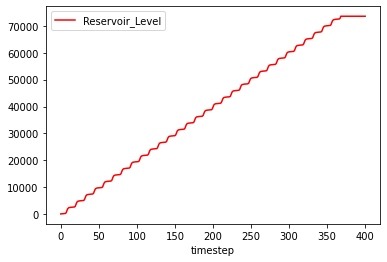

In [12]:
df.plot(x ='timestep', y=['Reservoir_Level'], kind = 'line', color = 'red')